In [1]:
%cd ../../

/media/olle/DATA/Projects/orderbookrl


In [2]:
from ray.rllib.models import ModelCatalog
from orderbookmdp.rl.market_order_envs import MarketOrderEnv
from orderbookrl.preprocessing.phi import MarketVariables
import time
from collections import deque

In [3]:
ModelCatalog.register_custom_preprocessor('mv', MarketVariables)
env = MarketOrderEnv(order_paths='data/feather/', snapshot_paths='data/snap_json/',
                     max_sequence_skip=10000, max_episode_time='1days', random_start=False)
options = {'custom_preprocessor': 'mv',
           'custom_options': {
               'fast_macd_l': 1200,
               'slow_macd_l': 2400,
               'ofi_l': 1000,
               'mid_l': 1000}
           }
env = ModelCatalog.get_preprocessor_as_wrapper(env, options)
t = time.time()

observations = deque()
mids = deque()

for i in range(2):
    k = 0
    obs = env.reset()
    done = False
    while not done:
        action = 0
        obs, reward, done, info = env.step(action)
        observations.append(obs)
        ask, ask_vol, bid, bid_vol = env.env.quotes
        mid = (ask+bid)/2
        mids.append(mid)
        k += 1
        if k % 10000 == 0:
            print(env.env.market.time, reward)
    print('stops', env.env.market.time)
print(time.time() - t)

Using custom preprocessor mv
data/feather/ data/snap_json/


/home/olle/miniconda3/envs/orderbookmdp/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/home/olle/miniconda3/envs/orderbookmdp/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



2018-03-24T17:54:31.390000Z 1.127522832421731e-06
2018-03-25T02:57:04.413000Z 0.0
stops 2018-03-25T08:38:12.098000Z
2018-03-25T17:05:27.070000Z 0.0
2018-03-26T01:54:27.886000Z 0.00040396407571232403
stops 2018-03-26T08:38:12.172000Z
141.750066280365


(49546,) (49546, 6)


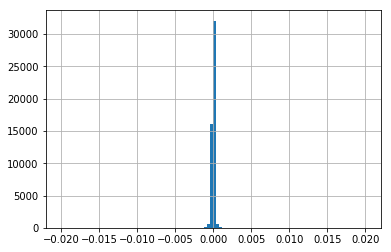

In [12]:
import pandas as pd
import numpy as np
%matplotlib inline

X = pd.DataFrame(list(observations))
y = pd.Series(list(mids))
y = y.pct_change().fillna(0)
X['pct_diff'] = y.shift(-1).fillna(0)
#y = np.sign(y)
y.clip(-0.02, 0.02).hist(bins=100);
print(y.shape, X.shape)

In [13]:
y.head(n=10)

0    0.000000e+00
1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5   -1.068533e-05
6   -5.623917e-07
7    0.000000e+00
8   -2.485773e-04
9   -2.025115e-05
dtype: float64

In [14]:
y.shift(1).head(n=10)

0             NaN
1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    0.000000e+00
6   -1.068533e-05
7   -5.623917e-07
8    0.000000e+00
9   -2.485773e-04
dtype: float64

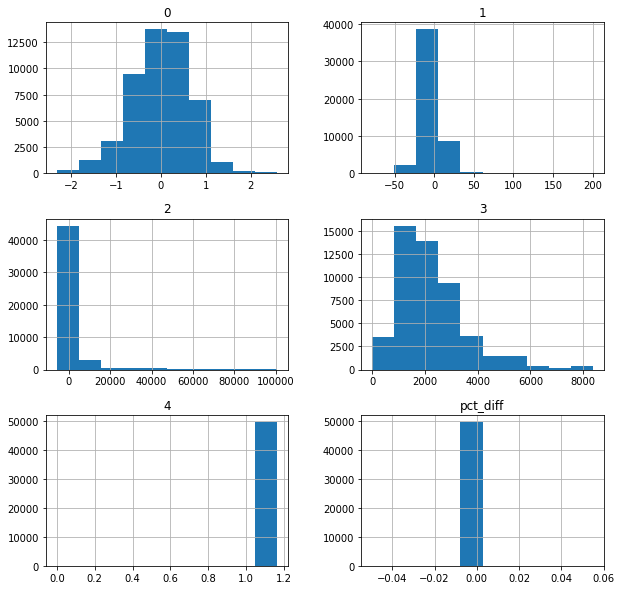

In [15]:
X.hist(figsize=(10,10));

In [16]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


def run_model(X, y, model, params, model_name, score, sign=False, weights=False):
    cv = TimeSeriesSplit()
    model = GridSearchCV(model, params, cv=cv, scoring=score, n_jobs=-1)
    X_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)
    
    if sign:
        w = np.abs(y)
        y = np.sign(y)
        
    if weights:
        result = model.fit(X, y, sample_weight=w)
    else:
        result = model.fit(X, y)
        
    print(model_name)
    print(result.best_params_)
    if sign:
        test_score = result.cv_results_['mean_test_score'].max()
        train_score = result.cv_results_['mean_train_score'].max()
        print('Test: {:.2f} Train:{:.2f}'.format(test_score, train_score))
    else:
        test_score = -result.cv_results_['mean_test_score'].max()
        train_score = -result.cv_results_['mean_train_score'].max()
        print('Test: {:.2e} Train:{:.2e}'.format(test_score, train_score))
    
    return result.best_estimator_

In [17]:
model = SGDRegressor(warm_start=True, max_iter=1000,
                    learning_rate='optimal')
params = {'penalty': ['l2','l1', 'elasticnet']}
model_name = 'sgd_reg'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

sgd_reg
{'penalty': 'l2'}
Test: 3.00e+33 Train:2.28e+35
28.3 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
from sklearn.svm import SVR
params = {'kernel':['linear', 'poly', 'rbf']}
model = SVR()
model_name = 'svr'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

svr
{'kernel': 'linear'}
Test: 2.89e-06 Train:2.79e-06
56 µs ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
params = {}
model_name = 'lin_reg'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

lin_reg
{}
Test: 1.56e-07 Train:6.06e-08
34.1 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
from sklearn.linear_model import Ridge
model = Ridge(solver='saga')
params = {'alpha': [0.5, 1, 3, 5, 10, 20, 50]}
model_name = 'ridge_reg'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

ridge_reg
{'alpha': 20}
Test: 1.68e-07 Train:7.19e-08
22.4 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(warm_start=True)
params = {'alpha': [0.5, 1, 3, 5, 10, 20, 50, 100],
         'l1_ratio': [0, 0.3, 0.6, 1]}
model_name = 'elastic_reg'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

elastic_reg
{'alpha': 20, 'l1_ratio': 0}
Test: 1.68e-07 Train:7.15e-08
28.4 µs ± 856 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
params = {}
model_name = 'bayes_reg'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

bayes_reg
{}
Test: 1.56e-07 Train:6.06e-08
28.1 µs ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
params = {'n_estimators': [10, 20, 50]}
model_name = 'rf_reg'
score = 'neg_mean_squared_error'
model = run_model(X, y, model, params, model_name, score)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

rf_reg
{'n_estimators': 50}
Test: 1.69e-07 Train:4.72e-08
2.21 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
model.predict(x_temp)

array([-1.39882887e-06])

# Classification

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(warm_start=True, max_iter=100,
                          solver='saga', multi_class='multinomial')
params = {'penalty': ['l2','l1'],
         'C': [0.1, 0.5, 1]}
model_name = 'log_reg'
score = 'f1_macro'
model = run_model(X, y, model, params, model_name, score, sign=True)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

log_reg
{'C': 1, 'penalty': 'l1'}
Test: 0.25 Train:0.30
28.2 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
model = LogisticRegression(warm_start=True, max_iter=100,
                          solver='saga', multi_class='multinomial')
params = {'penalty': ['l2','l1'],
         'C': [0.1, 0.5, 1]}
model_name = 'log_reg'
score = 'f1_macro'
model = run_model(X, y, model, params, model_name, score, sign=True, weights=True)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

log_reg
{'C': 0.1, 'penalty': 'l2'}
Test: 0.19 Train:0.28
30.6 µs ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(warm_start=True, max_iter=100)
params = {'penalty': ['l2','l1', 'elasticnet'],
         'alpha': [0.0001, 0.001],
         'l1_ratio': [0, 0.5, 1]}
model_name = 'sgd_class'
score = 'f1_macro'
model = run_model(X, y, model, params, model_name, score, sign=True)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

sgd_class
{'alpha': 0.001, 'l1_ratio': 0.5, 'penalty': 'l1'}
Test: 0.40 Train:0.38
32 µs ± 4.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
from sklearn.linear_model import Perceptron
model = Perceptron(warm_start=True, max_iter=1000)
params = {'penalty': ['l2','l1', 'elasticnet'],
         'alpha': [0.0001, 0.001]}
model_name = 'perc_class'
score = 'f1_macro'
model = run_model(X, y, model, params, model_name, score, sign=True)
x_temp = X.iloc[0,:].values.reshape(1, -1)
%timeit model.predict(x_temp)

perc_class
{'alpha': 0.0001, 'penalty': 'l2'}
Test: 0.29 Train:0.32
24.4 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
model.predict(x_temp)

array([0.])